In [1]:
# import the relevant libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson

In [2]:
# Load the data 
df = pd.read_csv('Olist_remove_no_correlated_no_item2.csv')
df.head()

,product_id,item_price,freight_value,payment_sequential,payment_type,payment_installments,order_purchase_timestamp,review_score,postal_code,state,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,sales_revenue
0,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,1,1,2,2017-09-13 08:59:00,5,28013,18,cool_stuff,650.0,28.0,9.0,14.0,58.9
1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,1,0,1,2017-06-28 11:52:00,5,75800,8,cool_stuff,650.0,28.0,9.0,14.0,55.9
2,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,1,1,2,2018-05-18 10:25:00,4,30720,10,cool_stuff,650.0,28.0,9.0,14.0,64.9
3,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,1,1,3,2017-08-01 18:38:00,5,83070,17,cool_stuff,650.0,28.0,9.0,14.0,58.9
4,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,1,1,4,2017-08-10 21:48:00,5,36400,10,cool_stuff,650.0,28.0,9.0,14.0,58.9


In [3]:
# Select the 'item_price'column 
cols = [ 'item_price']

# Calculate z-scores
z_scores = np.abs(stats.zscore(df[cols]))

# Create a new DataFrame with the z-scores
df_z_scores = pd.DataFrame(z_scores, columns=cols, index=df.index)

# Join the z-scores DataFrame with the original DataFrame
df = df.join(df_z_scores, rsuffix='_zscore')

# Keep only rows where all z-scores are less than 3
df = df[(df[[col + '_zscore' for col in cols]] < 3).all(axis=1)]

In [4]:
# Assign the X features.
X = df.drop(['sales_revenue', 'order_purchase_timestamp','product_category_name'], axis=1)

# Assign 'sales_revenue' column as the target variable 'y'.
y = df['sales_revenue']

In [5]:
# Keep a copy of the Product IDs for the test set before dropping from X
X_Product_IDs = X['product_id'].copy()

# Drop the Product ID from X
X = X.drop('product_id', axis=1)

# Split the data into train/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split train_val set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

In [6]:
# Define preprocessing for numerical columns (scale them)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline to train a linear regression model on the training set
pipeline.fit(X_train, y_train)

# Make predictions on the test set using the fitted model
y_pred_test = pipeline.predict(X_test)

# Create a DataFrame for the predictions, indexed by Product ID
df_predictions = pd.DataFrame({
    'product_id': X_Product_IDs.loc[X_test.index],
    'Actual': y_test,
    'Predicted': y_pred_test
})

print(df_predictions)

                              product_id  Actual   Predicted
107507  aeb767ca82c5a6cca8bbac33c4e21579  136.00   48.715739
40414   0da9ffd92214425d880de3f94e74ce39  112.00  134.674750
51022   2f13d1dc8b4e1d9d8027be50339546a9  105.00  122.616365
82904   3b66a296f7f9d4a5aa79ca89f460af73   33.80   36.853458
105162  9523f1a3e7db9e38d55379435bd450c9  134.17  149.284120
...                                  ...     ...         ...
5577    389d119b48cf3043d311335e499d9c6b   99.80   54.576406
41975   6ec26071510e1cf38d6988f473f8d7a5   69.90   74.893442
48747   67bd616e1ba0d3d3e8545f3113b0140d   14.49   13.040133
35601   5ad2b7b30050dd8aa51c2fed1db13e22   99.00  115.743589
69018   730f1927f42fda4370209c28203eb0ab   55.96   11.294107

[22658 rows x 3 columns]


In [7]:
# Make predictions on the train, validation, and test sets
y_pred_train = pipeline.predict(X_train)
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Calculate R-squared scores
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)

print('Train R2 score: ', r2_train)
print('Validation R2 score: ', r2_val)
print('Test R2 score: ', r2_test)

Train R2 score:  0.7115849100560732
Validation R2 score:  0.7182647145583503
Test R2 score:  0.6804496088880718


In [8]:
# Create a dataframe for the coefficients
coef_df = pd.DataFrame(pipeline.named_steps['regressor'].coef_, X.columns, columns=['Coefficient'])

# Append the intercept
coef_df = coef_df.append(pd.DataFrame([pipeline.named_steps['regressor'].intercept_], ['Intercept'], columns=['Coefficient']))

# Display the dataframe
print(coef_df)

                      Coefficient
item_price             101.419436
freight_value           -0.707632
payment_sequential       1.701225
payment_type            -3.745523
payment_installments     5.297088
review_score            -6.867657
postal_code              0.871077
state                    0.922641
product_weight_g         3.561936
product_length_cm        1.661618
product_height_cm        2.123429
product_width_cm        -1.658177
item_price_zscore       -1.824969
Intercept              117.215132


C:\Users\Work&Study\AppData\Local\Temp\ipykernel_15356\1603916518.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coef_df = coef_df.append(pd.DataFrame([pipeline.named_steps['regressor'].intercept_], ['Intercept'], columns=['Coefficient']))


In [9]:
df_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
print(df_compare)

        Actual   Predicted
107507  136.00   48.715739
40414   112.00  134.674750
51022   105.00  122.616365
82904    33.80   36.853458
105162  134.17  149.284120
...        ...         ...
5577     99.80   54.576406
41975    69.90   74.893442
48747    14.49   13.040133
35601    99.00  115.743589
69018    55.96   11.294107

[22658 rows x 2 columns]


In [10]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

Mean Absolute Error: 25.507590400940806
Mean Squared Error: 4937.3562393093825
Root Mean Squared Error: 70.26632365016248


In [11]:
# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Calculate MPE
mpe = np.mean((y_test - y_pred_test) / y_test) * 100

# Calculate PRMSE
prmse = (np.sqrt(np.mean((y_test - y_pred_test) ** 2)) / np.mean(y_test)) * 100

# Print the metrics
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
print("Mean Percentage Error (MPE): {:.2f}%".format(mpe))
print("Percentage Root Mean Squared Error (PRMSE): {:.2f}%".format(prmse))

Mean Absolute Percentage Error (MAPE): 23.05%
Mean Percentage Error (MPE): -10.69%
Percentage Root Mean Squared Error (PRMSE): 60.29%


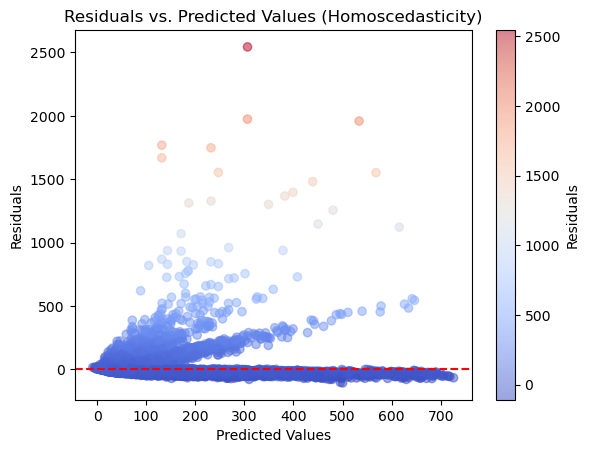

In [14]:
residuals = y_test - y_pred_test

# Plotting the residuals against the predicted values with color-coded data points
import matplotlib.pyplot as plt
plt.scatter(y_pred_test, residuals, alpha=0.5, c=residuals, cmap='coolwarm')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values (Homoscedasticity)')
plt.colorbar(label='Residuals')  # Add a colorbar indicating the range of residuals
plt.show()

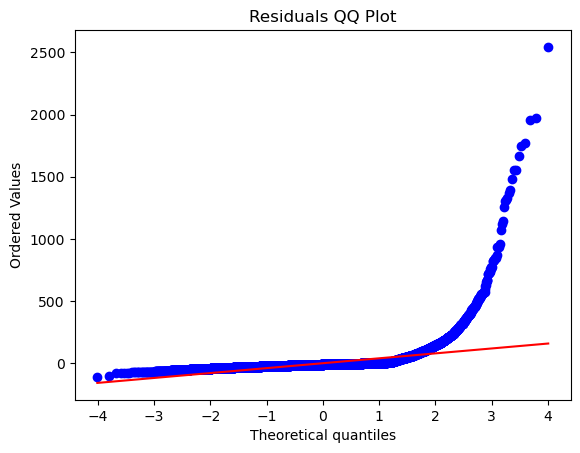

In [16]:
stats.probplot(residuals, plot=plt)
plt.title('Residuals QQ Plot')
plt.show()